In [1]:
import torch, math
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
from scipy.special import factorial
from math import factorial, sqrt, pi
import torch
import functorch
import torch.nn as nn
import torch.optim as optim

In [2]:
import importlib
import Master_funcs
importlib.reload(Master_funcs)

<module 'Master_funcs' from '/Users/aleksandersekkelsten/UIO/FYS4480/Master_funcs.py'>

In [3]:
def compute_energy(f_net, V=1.0, n_samples=int(1e4), L=2.0,step_size=0.1):
    device = next(f_net.parameters()).device
    #x = torch.empty(n_samples, 3, 1, device=device).uniform_(-L, L)
    x = generate_samples_with_metropolis(n_samples, f_net, n_thermalize=100,step_size=step_size)
    x.requires_grad_(True)
    
    psi = psi_plot_fn(x).squeeze()
    psi_sq = psi**2
    
    # Compute gradients for Laplacian
    grad_psi = torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
    laplacian = 0.0
    for p in range(3):  # sum over particles
        grad2 = torch.autograd.grad(grad_psi[:, p, 0].sum(), x, retain_graph=True)[0][:, p, 0]
        laplacian += grad2
    
    # Compute integrands for each term
    T_integrand = -0.5 * laplacian * psi
    V_harm_integrand = 0.5 * (x**2).sum(dim=(1,2)) * psi_sq
    V_int_integrand = compute_interaction_potential(x, V, 0.5).squeeze(-1) * psi_sq
    
    numerator_samples = T_integrand + V_harm_integrand + V_int_integrand
    denominator_samples = psi_sq
    
    # Compute means
    mean_numerator = numerator_samples.mean()
    mean_denominator = denominator_samples.mean()
    energy_value = (mean_numerator / mean_denominator).item()
    
    # Compute variances and covariance
    var_numerator = numerator_samples.var(unbiased=False)
    var_denominator = denominator_samples.var(unbiased=False)
    cov = torch.mean((numerator_samples - mean_numerator) * (denominator_samples - mean_denominator))
    
    # Calculate standard error
    variance_term = var_numerator + energy_value**2 * var_denominator - 2 * energy_value * cov
    standard_error = torch.sqrt(variance_term / n_samples) / mean_denominator
    standard_error = standard_error.item()
    
    return energy_value, standard_error

In [4]:
def symmetrized_nn_output(NN, x, n_permutations=10, permutations=None):
    """
    Enforces permutation symmetry by averaging NN outputs over several 
    permutations of the particle indices.
    
    Args:
        NN: A callable neural network that accepts input x of shape 
            (batch, n_particles, d).
        x: Tensor of shape (batch, n_particles, d).
        n_permutations: Number of permutations to average over.
        permutations: (Optional) A list of precomputed permutation indices of length n_permutations.
        
    Returns:
        A tensor with the averaged (symmetrized) output.
    """
    batch_size, n_particles, _ = x.shape
    outputs = []
    
    if permutations is None:
        # If no permutations are provided, generate them (not recommended within vmap)
        for _ in range(n_permutations):
            perm = torch.randperm(n_particles)
            outputs.append(NN(x[:, perm, :]))
    else:
        for perm in permutations:
            outputs.append(NN(x[:, perm, :]))
    
    outputs = torch.stack(outputs, dim=0)  # shape: (n_permutations, batch, output_dim)
    return outputs.mean(dim=0)

def symmetrized_exp_nn_output(NN, x, n_permutations=10, permutations=None):
    """
    Applies the exponential to the symmetrized NN output,
    implementing f(x)=exp(NN(x)).
    """
    return torch.exp(symmetrized_nn_output(NN, x, n_permutations, permutations))

def compute_laplacian_fast(psi_fn, x, permutations=None):
    """
    Compute the Laplacian of psi for a batch of configurations using functorch.jacrev.
    
    Args:
        psi_fn: A function mapping a single configuration x (shape: (n_particles, d))
                to a scalar psi (0-dim tensor). Must be pure.
        x: Tensor of shape (batch, n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.
        
    Returns:
        Tensor of shape (batch, 1) containing the Laplacian of psi.
    """
    batch, n_particles, d = x.shape
    D = n_particles * d
    # Flatten each configuration to shape (D,)
    x_flat = x.view(batch, D)
    
    def f(xx):
        # Reshape xx to (n_particles, d) and compute psi.
        return psi_fn(xx.view(n_particles, d), permutations=permutations)
    
    def single_hessian(xx):
        # Compute the Hessian via double jacrev.
        return functorch.jacrev(functorch.jacrev(f))(xx)
    
    # Vectorize single_hessian over the batch dimension.
    hessians = functorch.vmap(single_hessian)(x_flat)  # shape: (batch, D, D)
    # Laplacian is the trace of the Hessian.
    laplacian = torch.diagonal(hessians, dim1=1, dim2=2).sum(dim=1, keepdim=True)
    return laplacian

def psi_fn(x_single, permutations=None):
    """
    Compute the wavefunction for a single configuration.
    
    Args:
        x_single: Tensor of shape (n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.
    
    Returns:
        A scalar tensor representing psi.
    """
    # Add a batch dimension: shape (1, n_particles, d)
    x_batch = x_single.unsqueeze(0)
    SD_val = slater_determinant_from_C_occ_batch(x_batch, C_occ)  # Assumed to be defined globally.
    # Use the symmetrized exponential NN output.
    f_val = symmetrized_exp_nn_output(f_net, x_batch, n_permutations=2, permutations=permutations)
    psi_val = (SD_val * f_val).squeeze()  # Return a scalar tensor.
    return psi_val

In [5]:
def harmonic_oscillator_wavefunction(n, grid):
    """
    Compute the nth 1D harmonic oscillator eigenfunction using physicist's Hermite polynomials.
    """
    # Use Scipy's Hermite which returns physicist's H_n(x)
    from scipy.special import hermite
    Hn = hermite(n)(grid)
    norm = 1.0 / np.sqrt(2**n * factorial(n) * np.sqrt(np.pi))
    psi = norm * np.exp(-grid**2 / 2) * Hn
    return psi

def initialize_harmonic_basis(n_basis, grid):
    """
    Returns normalized basis functions using analytical normalization.
    """
    basis = np.zeros((len(grid), n_basis))
    for n in range(n_basis):
        basis[:, n] = harmonic_oscillator_wavefunction(n, grid)
    return basis

# ---------------------------
# One-Electron Integrals (Analytical Solution)
# ---------------------------
def one_electron_integral(n_basis):
    """
    Diagonal matrix with entries (n + 0.5) for HO eigenfunctions.
    """
    return np.diag(np.arange(n_basis) + 0.5)

# ---------------------------
# Two-Electron Integrals (Vectorized Computation)
# ---------------------------
def gaussian_interaction_potential(grid, V, sigma):
    X, Xp = np.meshgrid(grid, grid, indexing='ij')
    return V / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(X - Xp)**2 / (2 * sigma**2))

def compute_two_body_integrals(basis, V_interaction, grid):
    """
    Vectorized computation of two-electron integrals using matrix operations.
    """
    n_basis = basis.shape[1]
    dx = grid[1] - grid[0]
    n_grid = len(grid)
    
    # Generate Simpson weights for accurate integration
    weights = np.ones(n_grid)
    weights[1:-1:2] = 4
    weights[2:-1:2] = 2
    weights *= dx / 3.0
    W = np.outer(weights, weights)
    
    # Precompute product basis functions
    basis_products = basis[:, :, np.newaxis] * basis[:, np.newaxis, :]  # (n_grid, n_basis, n_basis)
    B = basis_products.reshape(n_grid, -1).T  # (n_basis^2, n_grid)
    
    # Compute weighted interaction matrix
    V_weighted = V_interaction * W
    
    # Matrix multiplication for all integrals
    integral_matrix = B @ V_weighted @ B.T  # (n_basis^2, n_basis^2)
    
    return integral_matrix.reshape(n_basis, n_basis, n_basis, n_basis)


In [6]:
def evaluate_basis_functions_torch_batch(x, n_basis):
    """
    Batched evaluation of 1D harmonic oscillator eigenfunctions.
    
    Args:
        x: Tensor of shape (B, N) with electron positions.
        n_basis: Number of basis functions to evaluate.
        
    Returns:
        Tensor of shape (B, N, n_basis) where each column is one basis function.
    """
    B, N = x.shape  # B=batch, N = number of electrons
    # Precompute the Gaussian factor (shape: (B, N))
    gauss = torch.exp(-x**2 / 2)
    
    # Precompute normalization factors
    norm0 = 1.0 / math.sqrt(math.sqrt(math.pi))
    phi0 = norm0 * gauss  # shape: (B, N)
    
    phi_list = [phi0]
    
    if n_basis > 1:
        norm1 = 1.0 / math.sqrt(2 * math.sqrt(math.pi))
        phi1 = norm1 * (2 * x) * gauss
        phi_list.append(phi1)
    
    if n_basis > 2:
        # Use vectorized recurrence for Hermite polynomials.
        H_prev_prev = torch.ones_like(x)  # H_0
        H_prev = 2 * x                     # H_1
        for n in range(1, n_basis - 1):
            H_curr = 2 * x * H_prev - 2 * n * H_prev_prev
            norm = 1.0 / math.sqrt((2**(n+1)) * math.factorial(n+1) * math.sqrt(math.pi))
            phi_n = norm * gauss * H_curr  # shape: (B, N)
            phi_list.append(phi_n)
            H_prev_prev, H_prev = H_prev, H_curr

    # Stack basis functions along a new last dimension -> shape: (B, N, n_basis)
    phi_vals = torch.stack(phi_list, dim=-1)
    return phi_vals

def slater_determinant_from_C_occ_batch(x_config, C_occ, normalize=True):
    """
    Compute the Slater determinant in a fully batched manner.
    
    Args:
        x_config: Tensor of shape (B, n_electrons, d), here assume d = 1,
                  so you can squeeze it to (B, n_electrons).
        C_occ:    Tensor of shape (n_basis, n_electrons) containing occupied orbital coefficients.
        normalize: If True, include the factor 1/sqrt(n_electrons!).
        
    Returns:
        Tensor of shape (B, 1) with the Slater determinant value for each configuration.
    """
    B, n_electrons, d = x_config.shape
    # For d=1, squeeze out the last dimension.
    x = x_config.squeeze(-1)  # shape: (B, n_electrons)
    n_basis = C_occ.shape[0]
    
    # Evaluate basis functions for all configurations at once.
    # phi_vals has shape (B, n_electrons, n_basis)
    phi_vals = evaluate_basis_functions_torch_batch(x, n_basis)
    
    # Build the molecular orbital matrix for each configuration.
    # psi_mat: (B, n_electrons, n_basis) @ (n_basis, n_electrons) -> (B, n_electrons, n_electrons)
    psi_mat = torch.matmul(phi_vals, C_occ)
    
    # Compute determinants in batch.
    det_vals = torch.linalg.det(psi_mat).view(B, 1)
    
    if normalize:
        det_vals = det_vals / math.sqrt(math.factorial(n_electrons))
    return det_vals


In [7]:
def compute_interaction_potential(x, V, sigma):
    batch_size, n_particles, d = x.shape
    V_int = torch.zeros(batch_size, device=x.device)
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r = x[:, i, :] - x[:, j, :]
            r_sq = (r**2).sum(dim=1)
            V_int += torch.exp(-r_sq / (2 * sigma**2))
    return (V / (sigma * np.sqrt(2 * np.pi))) * V_int.view(-1, 1)
    
def psi_plot_fn(positions):
    # positions: Tensor of shape (batch, n_particles, 1)
    SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # (batch, 1)
    f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=2)#f_net(positions).view(-1, 1)                        # (batch, 1)
    return SD_vals * f_vals   # (batch, 1)


In [8]:
L = 4
n_grid = 100
grid = np.linspace(-L, L, n_grid)
n_basis = 3
n_electrons = 3
n_particles=n_electrons
dimensions=1

# 1. Initialize basis (analytically normalized)
basis = initialize_harmonic_basis(n_basis, grid)

# 2. Compute one-electron integrals (instant)
Hcore = one_electron_integral(n_basis)

# 3. Gaussian interaction potential
V = 0#10
sigma = 0.5
V_interaction = gaussian_interaction_potential(grid, V, sigma)

# 4. Compute two-electron integrals (orders of magnitude faster)
print("Calculating two-electron integrals...")
two_body = compute_two_body_integrals(basis, V_interaction, grid)
print("Two-electron integrals computed.")
V=0
# 5. Run the Hartree-Fock procedure
print("Starting Hartree-Fock iterations...")
C_occ, orbital_energies = Master_funcs.hartree_fock(n_electrons, basis, grid, Hcore, two_body)
C_occ=torch.Tensor(C_occ)

Calculating two-electron integrals...
Two-electron integrals computed.
Starting Hartree-Fock iterations...
Iteration 0: Δ = 0.000e+00
4.5


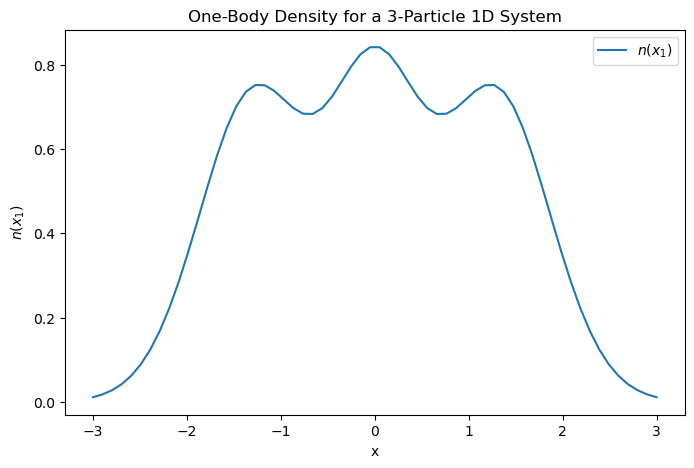

In [10]:
Ngrid = 60       # Number of grid points per particle coordinate
L=3
x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
positions = positions.unsqueeze(-1)

SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # shape: (Ngrid**n_particles, 1)
                   # shape: (Ngrid**n_particles, 1)
psi_vals = SD_vals                            # shape: (Ngrid**n_particles, 1)
#psi_vals = psi_plot_fn(positions)
psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
density = psi_sq.clone()
for axis in sorted(range(1, n_particles), reverse=True):
    density = torch.trapz(density, x_grid, dim=axis)
n_x = n_particles * density  # shape: (Ngrid,)

# --- 7. Plot the one-body density ---
x_vals = x_grid.detach().cpu().numpy()
n_vals = n_x.detach().cpu().numpy()

plt.figure(figsize=(8, 5))
plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
plt.xlabel('x')
plt.ylabel(r'$n(x_1)$')
plt.title(f'One-Body Density for a {n_particles}-Particle 1D System')
plt.legend()
plt.show()


In [11]:
def metropolis_step(x, C_occ, step_size=0.1):
    """
    One Metropolis-Hastings step to sample x from |ψ(x)|².
    x: (n_electrons, 1) for 1D
    """
    x_new = x + torch.randn_like(x) * step_size
    
    psi_sq_old = slater_determinant_from_C_occ_batch(x.unsqueeze(0), C_occ).squeeze()**2
    psi_sq_new = slater_determinant_from_C_occ_batch(x_new.unsqueeze(0), C_occ).squeeze()**2
    
    ratio = (psi_sq_new / (psi_sq_old + 1e-10)).clamp(min=0.0)
    if torch.rand(1) < ratio:
        return x_new
    else:
        return x

def generate_samples_with_metropolis(n_samples, C_occ, n_electrons=3, L=1.0,
                                     n_thermalize=1000, step_size=0.5, n_chains=100):
    """Parallel chain Metropolis sampling with corrected broadcasting"""
    # Initialize chains with shape (n_chains, n_electrons, 1)
    x = torch.empty(n_chains, n_electrons, 1).uniform_(-L, L)
    
    def metropolis_step(x_current):
        x_prop = x_current + torch.randn_like(x_current) * step_size
        psi_old = slater_determinant_from_C_occ_batch(x_current, C_occ).abs().squeeze() + 1e-8
        psi_new = slater_determinant_from_C_occ_batch(x_prop, C_occ).abs().squeeze() + 1e-8
        ratio = (psi_new**2 / psi_old**2).clamp(0, 1e5)
        # Create acceptance mask with proper dimensions
        accept_mask = (torch.rand(n_chains) < ratio).view(-1, 1, 1).expand_as(x_current)
        return torch.where(accept_mask, x_prop, x_current)

    # Thermalization
    for _ in range(n_thermalize):
        x = metropolis_step(x)
    
    # Sampling
    samples = []
    for _ in range(n_samples // n_chains + 1):
        x = metropolis_step(x)
        samples.append(x.clone())
    
    return torch.cat(samples)[:n_samples]


In [12]:
# Compare histograms of electron 0's x-coordinate
n_plot = 400000
x_target_plot = generate_samples_with_metropolis(n_plot, C_occ, n_electrons,step_size=0.6)
x_target_plot = x_target_plot

In [13]:
# define a model
from torchvision.ops import MLP
Mapper = MLP(in_channels=(n_particles+1), hidden_channels=[200,200, n_particles], activation_layer=torch.nn.SiLU)
optimizer = optim.Adam(list(Mapper.parameters()), lr=1e-3)

In [16]:
from tqdm import tqdm
criterion = torch.nn.MSELoss(reduction="none")

# train the model:
device='cpu'
d=1
num_epochs = 4000  # use fewer epochs if it takes too long
Grid=n_plot
batch_size = Grid
losses = []
batch_size_batch=10000
batches = Grid//batch_size_batch

y=x_target_plot
y=y.squeeze(-1)
for epoch in tqdm(range(num_epochs)):
    for batch in range(batches):
        x = torch.normal(0,1,size=(batch_size_batch,n_particles*d))
        #y = slater_determinant_from_C_occ_batch(x.unsqueeze(-1), C_occ)
        t = torch.rand(batch_size_batch)
        y_temp = y[batch*batch_size_batch:(batch+1)*batch_size_batch]
        #y_temp = generate_samples_with_metropolis(4000, C_occ, n_electrons,step_size=1).squeeze(-1)
        x, y_temp, t = x.to(device), y_temp.to(device), t.to(device)
        
        # TODO: implement the training loop
        psi_t = (1 - t.unsqueeze(-1))*x + t.unsqueeze(-1)*y_temp
        model_input = torch.cat([psi_t, t.unsqueeze(-1)], dim=-1)
        v_t = Mapper(model_input)
        
        # Loss 
        v_true = y_temp - x
        loss = criterion(v_t, v_true)  # Shape: (batch_size, 2)
        loss = loss.mean()
        losses.append(loss.item())
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%100==0:
        print(f"Epoch : {epoch:.4e}", f"Loss : {loss.item():.4f}")

  0%|                                        | 1/4000 [00:01<1:38:50,  1.48s/it]

Epoch : 0.0000e+00 Loss : 2.2172


  3%|▉                                     | 101/4000 [02:20<1:30:40,  1.40s/it]

Epoch : 1.0000e+02 Loss : 1.7706


  4%|█▍                                    | 153/4000 [03:32<1:29:10,  1.39s/it]


KeyboardInterrupt: 

In [17]:
def sample(Mapper,size):
    x0 = torch.normal(0,1,size=(size,n_particles*d))
    x = x0.to(device)
    t_values = torch.linspace(0, 1, 100 + 1, device=device)
    dt = t_values[1] - t_values[0]  # Time step size
    
    # Euler integration loop
    for t in t_values:
        t_tensor = t.expand(x.size(0), 1) 
        model_input = torch.cat([x, t_tensor], dim=-1)
        v_t = Mapper(model_input)
        x = x + dt * v_t
    return x

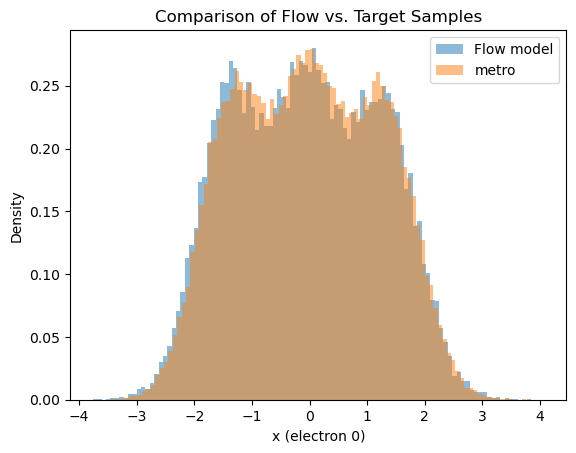

In [18]:
x = sample(Mapper, 40000).detach().numpy()
plt.figure()
plt.hist(x[:,0], bins=100, density=True, alpha=0.5, label="Flow model")
plt.hist(x_target_plot[:,0,0], bins=100, density=True, alpha=0.5, label="metro")
plt.xlabel("x (electron 0)")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of Flow vs. Target Samples")
plt.show()

In [19]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_hidden=1,act=nn.GELU()):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(act)
        for _ in range(n_hidden):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act)
        layers.append(nn.Linear(hidden_dim, 1))  # output a scalar correction factor
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        # x is of shape (batch_size, n_particles, d)
        # Flatten the input to (batch_size, n_particles * d)
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)
        return self.net(x_flat)


In [20]:
def train_model(V,E,f_net,optimizer,N_collocation=200,n_epochs=800,step_size=0.1):
    factor=0.001
    for epoch in range(n_epochs):
        #x = flow_model.sample(N_collocation)
        #x = generate_samples_with_metropolis(N_collocation, f_net, n_thermalize=20)
        x = sample(Mapper, N_collocation).unsqueeze(-1)
        optimizer.zero_grad()
        
        SD = slater_determinant_from_C_occ_batch(x, C_occ)
        n_permutations = 6
        perm_list = [torch.randperm(n_particles) for _ in range(n_permutations)]
        f_out= symmetrized_exp_nn_output(f_net, x, n_permutations=6)
        f_out=f_out.reshape(len(f_out))
        
        psi = SD * f_out
        norm=torch.norm(psi, p=2)
        psi=psi/norm
        laplacian = compute_laplacian_fast(psi_fn, x, permutations=perm_list)#compute_laplacian_fast(psi_fn, x)
        V_harmonic = 0.5 * (x**2).sum(dim=(1,2)).view(-1,1)
        V_int = compute_interaction_potential(x, V, 0.5)
        V_total = V_harmonic + V_int
        H_psi = -0.5 * laplacian + V_total * psi
        residual = H_psi - (E)*psi
        norm_loss = (norm - 1)**2
        if norm>=1e-2:
            factor*=0.9
        else:
            factor*=1.1
        loss_pde = torch.mean((residual)**2)
        variance = torch.var(H_psi/psi)
        loss = loss_pde + factor*norm_loss#+variance
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:05d}:  Pde Loss = {loss_pde.item():.3e}, "
                  f"Norm = {norm.item():.3e}", f"Variance = {variance.item():.3e}")
    return f_net

In [145]:
device="cpu"
d = 1
N_collocation = 400 # Number of collocation points per training iteration
learning_rate = 1e-3
n_epochs = 2000

# Test points
input_dim = n_particles * d
f_net = PINN(input_dim=input_dim, hidden_dim=200, n_hidden=2,act=nn.Mish()).to(device)
optimizer = optim.Adam(list(f_net.parameters()), lr=learning_rate)

In [22]:
train_model(0,4.5,f_net,optimizer,N_collocation=100,n_epochs=n_epochs)

/opt/anaconda3/lib/python3.9/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/opt/anaconda3/lib/python3.9/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


Epoch 00000:  Pde Loss = 2.047e-01, Norm = 1.746e+01 Variance = 2.997e+02
Epoch 00010:  Pde Loss = 1.032e-02, Norm = 3.629e+00 Variance = 6.257e+01
Epoch 00020:  Pde Loss = 6.344e-04, Norm = 1.430e+00 Variance = 1.246e+01
Epoch 00030:  Pde Loss = 2.812e-04, Norm = 8.706e-01 Variance = 9.703e+00
Epoch 00040:  Pde Loss = 2.206e-04, Norm = 6.842e-01 Variance = 1.012e+01
Epoch 00050:  Pde Loss = 2.586e-04, Norm = 7.063e-01 Variance = 1.155e+01
Epoch 00060:  Pde Loss = 2.593e-04, Norm = 6.871e-01 Variance = 1.033e+01
Epoch 00070:  Pde Loss = 2.400e-04, Norm = 6.503e-01 Variance = 9.808e+00
Epoch 00080:  Pde Loss = 2.176e-04, Norm = 7.052e-01 Variance = 4.391e+02
Epoch 00090:  Pde Loss = 1.900e-04, Norm = 6.411e-01 Variance = 3.880e+00
Epoch 00100:  Pde Loss = 2.254e-04, Norm = 7.504e-01 Variance = 7.816e+00
Epoch 00110:  Pde Loss = 1.736e-04, Norm = 7.104e-01 Variance = 4.006e+00
Epoch 00120:  Pde Loss = 1.466e-04, Norm = 7.406e-01 Variance = 2.787e+01
Epoch 00130:  Pde Loss = 2.093e-04, No

KeyboardInterrupt: 

In [23]:
def compute_energy(f_net, V=1.0, n_samples=int(1e4), L=2.0):
    device = next(f_net.parameters()).device
    x = torch.empty(n_samples, n_particles, 1, device=device).uniform_(-L, L)
    #x = generate_samples_with_metropolis(n_samples, f_net, n_thermalize=1000,step_size=step_size)
    x.requires_grad_(True)
    
    psi = psi_plot_fn(x).squeeze()
    psi_sq = psi**2
    
    # Compute gradients for Laplacian
    grad_psi = torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
    laplacian = 0.0
    for p in range(n_particles):  # sum over particles
        grad2 = torch.autograd.grad(grad_psi[:, p, 0].sum(), x, retain_graph=True)[0][:, p, 0]
        laplacian += grad2
    
    # Compute integrands for each term
    T_integrand = -0.5 * laplacian * psi
    V_harm_integrand = 0.5 * (x**2).sum(dim=(1,2)) * psi_sq
    V_int_integrand = compute_interaction_potential(x, V, 0.5).squeeze(-1) * psi_sq
    
    numerator_samples = T_integrand + V_harm_integrand + V_int_integrand
    denominator_samples = psi_sq
    
    # Compute means
    mean_numerator = numerator_samples.mean()
    mean_denominator = denominator_samples.mean()
    energy_value = (mean_numerator / mean_denominator).item()
    
    # Compute variances and covariance
    var_numerator = numerator_samples.var(unbiased=False)
    var_denominator = denominator_samples.var(unbiased=False)
    cov = torch.mean((numerator_samples - mean_numerator) * (denominator_samples - mean_denominator))
    
    # Calculate standard error
    variance_term = var_numerator + energy_value**2 * var_denominator - 2 * energy_value * cov
    standard_error = torch.sqrt(variance_term / n_samples) / mean_denominator
    standard_error = standard_error.item()
    
    return energy_value, standard_error

In [24]:
compute_energy(f_net, V=0.0, n_samples=int(1e4), L=2.9)

(4.505207061767578, 0.0013846928486600518)

In [180]:
optimizer = optim.Adam(list(f_net.parameters()), lr=1e-3)
train_model(-10,0.7,f_net,optimizer,N_collocation=500,n_epochs=n_epochs)

Epoch 00000:  Pde Loss = 1.033e-05, Norm = 3.097e-01 Variance = 6.253e+00
Epoch 00010:  Pde Loss = 1.244e-05, Norm = 6.284e-01 Variance = 6.151e+00
Epoch 00020:  Pde Loss = 2.716e-05, Norm = 1.068e+00 Variance = 7.635e+00
Epoch 00030:  Pde Loss = 1.612e-05, Norm = 8.059e-01 Variance = 6.381e+00
Epoch 00040:  Pde Loss = 1.106e-05, Norm = 5.456e-01 Variance = 5.487e+00
Epoch 00050:  Pde Loss = 1.055e-05, Norm = 4.686e-01 Variance = 5.542e+00
Epoch 00060:  Pde Loss = 9.764e-06, Norm = 4.516e-01 Variance = 5.594e+00
Epoch 00070:  Pde Loss = 9.536e-06, Norm = 4.269e-01 Variance = 5.473e+00
Epoch 00080:  Pde Loss = 1.071e-05, Norm = 4.128e-01 Variance = 5.464e+00
Epoch 00090:  Pde Loss = 9.265e-06, Norm = 4.103e-01 Variance = 5.871e+00


KeyboardInterrupt: 

In [25]:
optimizer = optim.Adam(list(f_net.parameters()), lr=1e-3)
train_model(10,5.87,f_net,optimizer,N_collocation=100,n_epochs=n_epochs)

Epoch 00000:  Pde Loss = 2.643e-04, Norm = 9.597e-01 Variance = 5.427e+00
Epoch 00010:  Pde Loss = 1.404e-04, Norm = 9.055e-01 Variance = 2.444e+00
Epoch 00020:  Pde Loss = 1.681e-04, Norm = 1.025e+00 Variance = 5.810e+00
Epoch 00030:  Pde Loss = 1.534e-04, Norm = 1.032e+00 Variance = 4.679e+00
Epoch 00040:  Pde Loss = 1.428e-04, Norm = 1.037e+00 Variance = 4.568e+00
Epoch 00050:  Pde Loss = 1.354e-04, Norm = 1.026e+00 Variance = 4.162e+00
Epoch 00060:  Pde Loss = 1.331e-04, Norm = 1.056e+00 Variance = 4.674e+00
Epoch 00070:  Pde Loss = 1.638e-04, Norm = 9.088e-01 Variance = 5.508e+00
Epoch 00080:  Pde Loss = 1.268e-04, Norm = 1.023e+00 Variance = 3.472e+00
Epoch 00090:  Pde Loss = 1.500e-04, Norm = 1.015e+00 Variance = 3.225e+00
Epoch 00100:  Pde Loss = 1.558e-04, Norm = 9.907e-01 Variance = 5.715e+00
Epoch 00110:  Pde Loss = 1.279e-04, Norm = 9.025e-01 Variance = 3.592e+00
Epoch 00120:  Pde Loss = 1.234e-04, Norm = 1.063e+00 Variance = 3.518e+00
Epoch 00130:  Pde Loss = 1.184e-04, No

KeyboardInterrupt: 

In [181]:
compute_energy(f_net, V=-10.0, n_samples=int(1e4), L=3.)

(1.3050578832626343, 0.04190755635499954)

In [77]:
optimizer = optim.Adam(list(f_net.parameters()), lr=1e-3)
train_model(20,6.5,f_net,optimizer,N_collocation=100,n_epochs=n_epochs)

Epoch 00000:  Pde Loss = 9.684e-04, Norm = 2.447e-02 Variance = 2.449e+01
Epoch 00010:  Pde Loss = 8.207e-04, Norm = 4.916e-01 Variance = 1.992e+01
Epoch 00020:  Pde Loss = 5.600e-04, Norm = 8.647e-01 Variance = 1.620e+01
Epoch 00030:  Pde Loss = 6.190e-04, Norm = 8.840e-01 Variance = 2.083e+01
Epoch 00040:  Pde Loss = 5.531e-04, Norm = 9.371e-01 Variance = 1.638e+01
Epoch 00050:  Pde Loss = 5.524e-04, Norm = 8.735e-01 Variance = 1.905e+01
Epoch 00060:  Pde Loss = 6.317e-04, Norm = 9.979e-01 Variance = 2.022e+01
Epoch 00070:  Pde Loss = 5.056e-04, Norm = 1.032e+00 Variance = 1.473e+01
Epoch 00080:  Pde Loss = 5.722e-04, Norm = 7.871e-01 Variance = 2.046e+01
Epoch 00090:  Pde Loss = 5.223e-04, Norm = 8.661e-01 Variance = 1.926e+01
Epoch 00100:  Pde Loss = 4.098e-04, Norm = 1.005e+00 Variance = 1.818e+01
Epoch 00110:  Pde Loss = 6.826e-04, Norm = 6.277e-01 Variance = 2.120e+01
Epoch 00120:  Pde Loss = 4.973e-04, Norm = 6.157e-01 Variance = 4.282e+01
Epoch 00130:  Pde Loss = 6.233e-04, No

KeyboardInterrupt: 

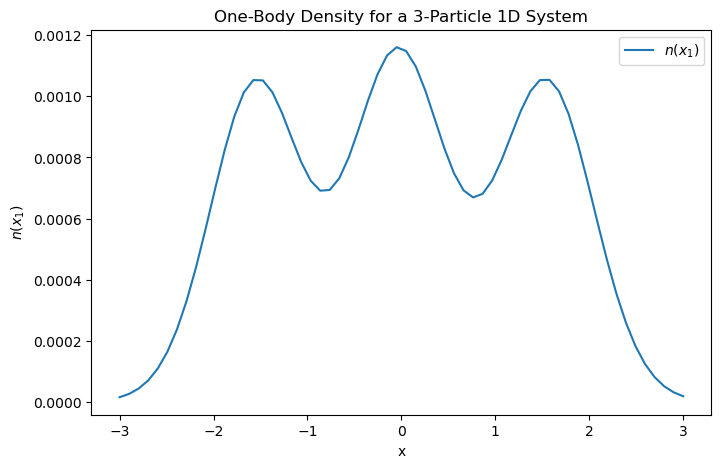

In [87]:

Ngrid =60       # Number of grid points per particle coordinate
L=3
x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
positions = positions.unsqueeze(-1)

SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # shape: (Ngrid**n_particles, 1)
                   # shape: (Ngrid**n_particles, 1)
psi_vals = SD_vals                            # shape: (Ngrid**n_particles, 1)
psi_vals=psi_plot_fn(positions)
psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
density = psi_sq.clone()
for axis in sorted(range(1, n_particles), reverse=True):
    density = torch.trapz(density, x_grid, dim=axis)
n_x = n_particles * density  # shape: (Ngrid,)

# --- 7. Plot the one-body density ---
x_vals = x_grid.detach().cpu().numpy()
n_vals = n_x.detach().cpu().numpy()

plt.figure(figsize=(8, 5))
plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
plt.xlabel('x')
plt.ylabel(r'$n(x_1)$')
plt.title(f'One-Body Density for a {n_particles }-Particle 1D System')
plt.legend()
plt.show()


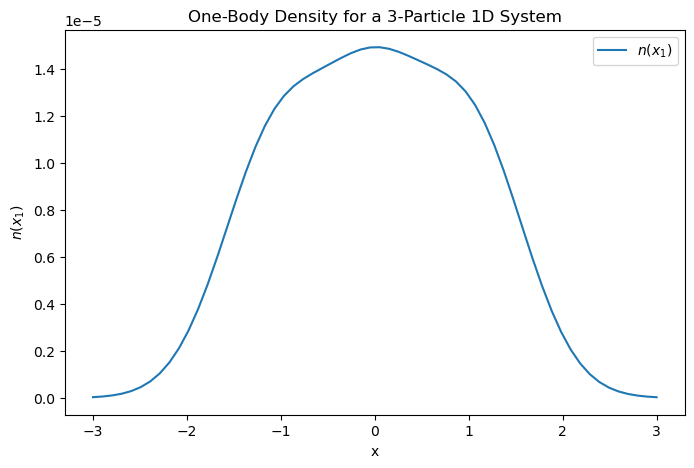

In [179]:

Ngrid =60       # Number of grid points per particle coordinate
L=3
x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
positions = positions.unsqueeze(-1)

SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # shape: (Ngrid**n_particles, 1)
                   # shape: (Ngrid**n_particles, 1)
psi_vals = SD_vals                            # shape: (Ngrid**n_particles, 1)
psi_vals=psi_plot_fn(positions)
psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
density = psi_sq.clone()
for axis in sorted(range(1, n_particles), reverse=True):
    density = torch.trapz(density, x_grid, dim=axis)
n_x = n_particles * density  # shape: (Ngrid,)

# --- 7. Plot the one-body density ---
x_vals = x_grid.detach().cpu().numpy()
n_vals = n_x.detach().cpu().numpy()

plt.figure(figsize=(8, 5))
plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
plt.xlabel('x')
plt.ylabel(r'$n(x_1)$')
plt.title(f'One-Body Density for a {n_particles }-Particle 1D System')
plt.legend()
plt.show()
